# Scraping the Courts and Tribunals Judiciary Website to collect Prevent Future Death (PFD) reports 

In [1]:
from requests import get
from requests import ConnectionError
from bs4 import BeautifulSoup
import re
from time import sleep
from time import time
import csv
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from tqdm.contrib import tzip

import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

import concurrent

from time import sleep, time

import SymSpellCppPy

from datetime import date

def get_url(url):
    return BeautifulSoup(get(url, verify = False).content, "html.parser")

def retries(record_url, tries=3):
    for i in range(tries):
        try:
            soup = get_url(record_url)
            return soup
        except (ConnectionError, SSLError):
            sleep(2)
            continue
    raise ConnectionError(f"Exceeded {tries} tries")

# Scraper

Here we find the number of pages containing PFD reports.

In [2]:
prefix = "https://www.judiciary.uk/subject/prevention-of-future-deaths/"
number_of_pages = int(get_url(prefix) \
                    .find("div", "pagination") \
                    .find_all("li")[-1] \
                    .find("a")["href"] \
                    .split("/")[-2])

In [3]:
def fetch_urls(page):
    soup = retries(prefix+"/page/{}".format(str(page+1)))
    h5s = soup.find_all('h5', {'class': 'entry-title'})
    return [h5.a.get('href') for h5 in h5s]

In [4]:
record_urls = []
with tqdm(total = number_of_pages) as pbar:
    with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
        record_urls = [executor.submit(fetch_urls, i)
                       for i in range(number_of_pages)]
        for future in concurrent.futures.as_completed(record_urls):
            pbar.update(1)
record_urls = [link for links in # flatten the list
                   [urls.result() for urls in record_urls]
                   for link in links]

  0%|          | 0/372 [00:00<?, ?it/s]

Some technical remarks: we make all our web requests here to avoid repeatedly making requests to the judiciary’s website. Since `concurrent` must pickle the object we can’t nicely handle exceptions so just have to check the output of `download_html` later for strings beginning `Error: ` (on the assumption that most pages won’t start `Error: `.)

Only the download part is parallelised, on the assumption that downloads are slow but relatively simple to parallelise, and all other operations are finicky but are fast even on a single thread.

It is envisaged that there should be no need to refresh these cells so as to save time.

In [5]:
def download_html(url, tries=5):
    try:
        for i in range(tries):
            try:
                return get(url)
            except (ConnectionError, SSLError):
                sleep(2)
                continue
    except Exception as e:
        if isinstance(e, ConnectionError):
            return "Error: Connection error"
        else:
            return f"Error: {str(e)}"

In [6]:
with tqdm(total = len(record_urls)) as pbar:
    with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
        raw = [executor.submit(download_html, url) for url in record_urls]
        for future in concurrent.futures.as_completed(raw):
            pbar.update(1)

  0%|          | 0/3720 [00:00<?, ?it/s]

In [7]:
class MissingRecordsError(Exception): pass
class MissingFieldError(Exception): pass
class UnreadableFieldError(Exception): pass
class FieldError(Exception): pass
class SpecialCaseUnaccountedForError(Exception): pass
class TooManyTriesError(Exception): pass
class MissingDownloadBoxError(Exception): pass

special_cases = [
    "https://www.judiciary.uk/publications/roadsafety/",
    "https://www.judiciary.uk/publications/helen-sheath/",
    "https://www.judiciary.uk/publications/rebecca-evans/"
]

columns = list(map(lambda x: x.lower(), [
    'Date of report',
    'Ref',
    'Deceased name',
    'Coroner name',
    'Coroner Area',
    'Coroners Area', #NB to be merged later; if both come up there'll be trouble
    'Category',
    "This report is being sent to"
]))

records, refs, pdflinks = [], [], []

plurals_possessives = re.compile(r"’s\s|s\s|'s\s")

In [8]:
class Extractor(object):
    def __init__(self, raw_with_url):
        try:
            self.url = raw_with_url[0]
            self.extracted = {"url": self.url, "errors": []}

            self.result = raw_with_url[1].result()
            
            if isinstance(self.result, str):
                if self.result.startswith("Error:"):
                    raise ConnectionError
            
            self.read_fields()
            self.count_files()
        except Exception as e:
            self.handle_exception(e)
            
    def read_fields(self):
        self.soup = BeautifulSoup(self.result.content)
        self.information_area = self.soup.find("div", {"class": "entry-content"})

        if not self.information_area:
            raise MissingRecordsError         

        self.information = self.information_area.find_all("p")

        # nothing between <p> to process
        if not self.information:
            raise MissingRecordsError         
        
        if self.url in special_cases:
            self._process_special_case(self.url)
        else:
             for field in self.information:
                self.strip_field(field)

    def count_files(self):
        download_box = self.soup.find("div", "download-box")

        if download_box:
            links = download_box.find_all('a', href=True)
            responses = len([s for s in links if "response" in s.text.lower()])
        else:
            raise MissingDownloadBoxError

        pdflinks.append([link.href for link in links])

        self.extracted["number of links"] = len(links)
        self.extracted["number of responses"] = responses

        try:
            self.extracted["number of recipients"] = self.extracted["this report is being sent to"].count(";") + 1
        except:
            pass

        try:
            if self.extracted["ref"] in refs: # deduplication of references
                self.extracted["ref"] += "-bis"
            refs.append(self.extracted["ref"])
        except KeyError:
            self.extracted["ref"] = "autogenerated-ref" # no reference found
    
    def handle_exception(self, e):
        details = str(e)
        if isinstance(e, ConnectionError):
            details = "Could not connect"
        if isinstance(e, MissingRecordsError):
            details = "No records found"
        if isinstance(e, SpecialCaseUnaccountedForError):
            details = "Special case unaccounted for"
        if isinstance(e, MissingFieldError):
            details = f"Missing header: {e}"
        if isinstance(e, AttributeError):
            details = f"Attribute error: {e}"
        if isinstance(e, MissingDownloadBoxError):
            details = f"Missing download box."
        print(f"At {self.url}, {details}")
        self.extracted["errors"].append({"url": self.url, "reason": details})

    def strip_field(self, field):
        try:
            extraction = self.FieldStripper(field, self.url)
            self.extracted[extraction.header] = extraction.text
            if extraction.error is not None:
                self.extracted["errors"].append(extraction.error)
        except FieldError:
            self.extracted["errors"].append({"url": self.url, "reason": f"Field error: {field}"})
            
    def _process_special_case(self,url):
        if self.url == 'https://www.judiciary.uk/publications/roadsafety/':
            fields = self.information[0].find_all('strong')
            heads = ['date of report',
                     'ref',
                     'deceased name',
                     'coroner name',
                     'coroner area',
                     'category']
            for field, h in zip(fields,heads):
                self.extracted[h] = field.next_sibling.replace(':','').replace('Ref','').strip()
        elif url == 'https://www.judiciary.uk/publications/helen-sheath/':
            fields = self.information[0].text.split('\n')
            vals = [field.split(":") for field in fields]
            for v in vals:
                if v[0] == "Coroners name":
                    alt = "coroner_name"
                elif v[0] == "Coroners Area":
                    alt = "coroner_area"
                else:
                    alt = v[0].strip().lower()
                self.extracted[alt] = v[1].strip().replace('\n','')
        elif url == "https://www.judiciary.uk/publications/rebecca-evans/":
            for field in self.information:
                if "Rebecca-EvansR" in field.text:
                    self.extracted["category"] = field.text.split(':')[1].strip().replace('\n','')
                else:
                    self.strip_field(field)

        else:
            raise SpecialCaseUnaccountedForError

            
            
    class FieldStripper(object):
        def __init__(self, field, url):
            try:
                self.error = None
                self.url = url
                self.field_text = field.text.strip()
                self.text = ""

                if self.field_text.replace('\xa0','').strip() == "": raise MissingFieldError

                    
                if ":" in self.field_text:
                    self.pre_colon, self.post_colon = self.field_text.split(":", 1) # split by first colon
                else:
                    self.pre_colon = self.field_text
                    self.post_colon = ""
                
                
                self.header = self.pre_colon.lower()
                
                if self.header in columns: # Normal case: colon separates text
                    self.text = self.post_colon.strip().replace('\n','').replace('\xa0','')
                elif self.post_colon.strip() == "": # no colon separator
                    self.header, self.text = self._no_colon_separator()          
                elif self.field_text.count(":") == 2: # two colons
                    self.header, self.text = self._two_colons()
                elif ':' in self.field_text and self.header not in columns: # plurals and possessives
                    self.header, self.text = self._plurals_and_possessives()
                else:
                    print(self.field_text)
                
            except Exception as e:
                details = str(e)
                if isinstance(e, UnreadableFieldError):
                    details = f"Unreadable field; text read: {field.text}"              
                if isinstance(e, MissingFieldError):
                    details = f"Unreadable field; text read: {field.text}"              
                self.error = {"url": self.url, "reason": details}
                raise FieldError

        def _no_colon_separator(self):
            column_found = False
            for column in columns:
                if self.pre_colon.startswith(column):
                    header = column
                    text = pre_colon[len(column)+1] \
                            .replace('\n','') \
                            .replace('\xa0','')
                    column_found = True
                    break
            if not column_found:
                raise UnreadableFieldError
            return (header, text)

        def _two_colons(self):
            split_by_colon = self.field_text.split(':')
            header = re.sub(plurals_possessives,
                             ' ',
                             split_by_colon[0]+split_by_colon[1]
                            ) \
                            .strip() \
                            .lower()
            text = split_by_colon[2] \
                        .strip() \
                        .replace('\n','') \
                        .replace('\xa0','')
            return (header, text)

        def _plurals_and_possessives(self):
            if 'Name of' in self.field_text:
                header = self.pre_colon.split(' ')[2] + " name"
                text = self.field_text[-1].strip().replace('\n','').replace('\xa0','')
            else:     
                header = re.sub(plurals_possessives, ' ', self.pre_colon).strip().lower()
                text = self.post_colon.strip().replace('\n','').replace('\xa0','')
            return (header, text)

def page_scrape(raw_with_url):
    scraper = Extractor(raw_with_url)
    return scraper.extracted

In [9]:
records = [page_scrape(page) for page in tzip(record_urls, raw)]
errors = [record["errors"] for record in records if record["errors"] != []]

  0%|          | 0/3720 [00:00<?, ?it/s]

At https://www.judiciary.uk/publications/john-long/, Missing download box.
At https://www.judiciary.uk/publications/patricia-parker/, Missing download box.
At https://www.judiciary.uk/publications/railwayrelateddeaths/, No records found
At https://www.judiciary.uk/publications/service-personnel-deaths/, No records found
At https://www.judiciary.uk/publications/product/, No records found
At https://www.judiciary.uk/publications/policerelateddeaths/, No records found
At https://www.judiciary.uk/publications/carehomehealth/, No records found
At https://www.judiciary.uk/publications/statecustodydeath/, No records found
At https://www.judiciary.uk/publications/hospitaldeath/, No records found
At https://www.judiciary.uk/publications/drugsalcoholmedication/, No records found
At https://www.judiciary.uk/publications/commhealthcareemergencyservices/, No records found


We place `records` into a data frame and merge different labels for the same field.

In [201]:
df = pd.DataFrame(records)
df["coroner area"] = df["coroner area"].fillna(df["coroners area"])
df["date of report"] = df["date of report"].fillna(df["date of reports"])

Here we plot the number of reports every month.

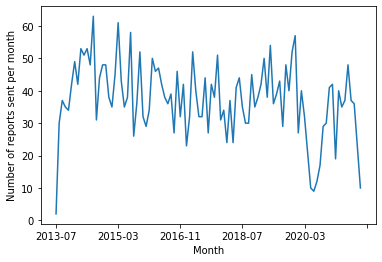

In [202]:
df["date of report"] = pd.to_datetime(df["date of report"], errors = 'coerce')
df["year-month"] = df["date of report"].dropna().apply(lambda dmy: dmy.strftime('%Y-%m'))
date_counts = df["year-month"].dropna().value_counts().sort_index()

date_plot = date_counts.plot

plt.xlabel("Month")
plt.ylabel("Number of reports sent per month")

date_plot.line()

plt.savefig("reports-per-month.png")
plt.savefig("reports-per-month.svg")

It is slightly more involved to do so, but here we plot the response rate. We categorise the response rate into threee categories—
1. where no response is received,
2. where fewer responses are received than the number of bodies to which the report was sent, and
3. when the number of responses received is equal to or greater than the number of bodies to which the report was sent.

We adopt this rather convoluted scheme because in certain cases multiple responses are received even though the report was only sent to one body (for example, a CCG may respond in addition to someone from a particular hospital).

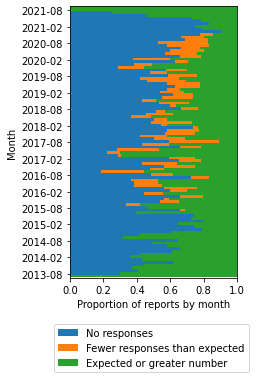

In [203]:
def get_response_rate(row):
    if row["number of responses"] == 0:
        return "no response received"
    elif row["number of responses"] < row["number of recipients"]:
        return "fewer responses than expected received"
    else:
        return "expected or greater number of responses received"

response_rates = df.loc[:,["year-month", "number of responses", "number of recipients"]]
response_rates["response"] = response_rates.apply(get_response_rate, axis=1)
response_rates = response_rates \
        .groupby(["year-month"])["response"] \
        .value_counts() \
        .to_frame() \
        .unstack() \
        .fillna(0)

proportions = response_rates.div(response_rates.sum(axis=1), axis=0)

proportions_plot = proportions.plot(kind="barh",stacked=True, figsize=(3,5))

for container in proportions_plot.containers:
    plt.setp(container, height=1)
    
plt.tick_params(axis='both', which='both')

plt.xlabel("Proportion of reports by month")
plt.ylabel("Month")

plt.yticks(plt.yticks()[0][1::6], 
           plt.yticks()[1][1::6])

plt.legend(labels=["No responses", "Fewer responses than expected", "Expected or greater number"],bbox_to_anchor=(1.1,-0.15))
plt.margins(0)

plt.savefig("responses-over-time.svg",bbox_inches='tight')
plt.savefig("responses-over-time.png",bbox_inches='tight')

plt.show()

We save the file twice, possibly overwriting `death_info_latest.csv` so that `index.html` can point to the same location and it doesn’t need to be changed.

We now generate a Markdown file containing some summary statistics and a more presentable view of the charts.

In [206]:
errors_sans_field_errors = len([page for page in errors if all("Field error" not in error["reason"] for error in page)])
number_no_response = df[df["number of responses"] > 0].count()["number of responses"]

In [207]:
md = f"""
# Some summary statistics

As of {str(date.today().strftime("%d/%m/%Y"))}, the judiciary
has uploaded {len(record_urls) - errors_sans_field_errors}
reports. 
{df[df["number of responses"] == 0].count()["number of responses"]}
of them are unresponded to.
{df[df["number of responses"] > 0].count()["number of responses"]} 
of them haWe save the file twice, possibly overwriting death_info_latest.csv so that index.html can point to the same location and it doesn’t need to be changed.
ve received at least one response. And
{df[df["number of responses"] >= df["number of recipients"]].count()["number of responses"]}
have received the expected number of responses or more.

The expected number of responses is calculated by finding the number
of recipients of a report. In some cases, interested parties not
initially named as respondents also respond. Due to an absence of
machine-readable data, it is difficult to devise more informative schemas
that remain robust.

Figure 1: number of reports sent per month

![Number of reports sent per month](./reports-per-month.svg)
<img src="https://github.com/georgiarichards/georgiarichards.github.io/blob/master/data/reports-per-month.svg">

<object data="https://github.com/georgiarichards/georgiarichards.github.io/blob/master/data/reports-per-month.svg" type="image/svg+xml">
  <img src="https://github.com/georgiarichards/georgiarichards.github.io/blob/master/data/reports-per-month.png" />
</object>

Figure 2: response rates by month

![Response rates by month](./responses-over-time.svg)
<img src="https://github.com/georgiarichards/georgiarichards.github.io/blob/master/data/responses-over-time.svg">

"""

with open("summary_statistics.md", "w") as f:
    f.write(md)

# Areas

## Cleaning up the area field

Coroner areas ‘loosely mirror the boundaries established by local authority districts’ [according to the Crown Prosecution Service](https://www.cps.gov.uk/legal-guidance/coroners). Some are, however, merged. We first attempt to clean up the data so as to populate `by_la["corrected area"]` (possibly containing a singular local authority but a list at any rate.)

The judiciary’s website is full of typos, so I first attempt to clean up the area column. We encounter a number of issues; the most annoying ones were that—

- rather impressively, Coventry and Warwickshire is [not a single coroner area](https://api.warwickshire.gov.uk/documents/WCCC-1265161770-1017) but a coroner is appointed for both separate areas; and
- some reports list e.g. ‘London’ as the area, which is not enough information (I could make them edge cases but if this happens again we might incorrectly assign them all to Inner London (East) or something, so I simply discard them.)

The intermediate stages of this computation are very dodgy! The end result only contains coronial areas as of today, but in intermediate stages a mix may be present.

In [280]:
present_areas = pd.read_csv("areas_2020.csv",header=None)[0]
amalgamations = pd.read_csv("amalgamations.tsv",sep='\t')
amalgamations["Old areas"] = amalgamations["Old areas"].str.split("; ")
amalgamations["New area(s)"] = amalgamations["New area(s)"].str.split("; ")
amalgamations = amalgamations.explode("New area(s)").explode("Old areas")
conversions = dict(zip(amalgamations["Old areas"].dropna(),amalgamations["New area(s)"]))
all_areas = list(np.concatenate(
        (present_areas,
        amalgamations["Old areas"].str.split("; ").explode().dropna().unique())
))
for area in present_areas:
    conversions[area] = area

In [281]:
replacements = [
    ["kent \(south east \& central\)", "central_south_east_kent"],
    ["north.*(east|central|wales).*(east|central|wales).*(east|central|wales)", "north east north central wales"],
    ["\(e\)", "east"],
    ["london \(city\)", "city of london"],
    [".*(hampshire|portsmouth).*", "hampshire_portsmouth_southampton"],
    ["birmingham$", "birmingham_solihull"],
    ["(coroner service|coroner’s court|coroner)", ""],
    [".*knowsley.*", "sefton_knowsley_st_helens"],
    [".*nottingham.*", "nottinghamshire"],
    [".*cumbria.*", "cumbria"],
    [".*derby.*", "derby_derbyshire"],
    [".*(lancashire|blackburn).*", "lancashire_blackburn_darwen"],
    [".*east riding.*", "east_riding_hull"],
    [".*? north tyneside", "north tyneside"],
    [".*leicester.*(south|city).*|.*south.*leicester.*", "leicestershire_south_leicestershire"],
    ["pembrokeshire & camarthenshire", "carmarthenshire_pembrokeshire"],
    ["coventry and warwickshire", "warwickshire"],
    ["-", " "],
    ["\: ", ""],
    ["&", "and"],
    ["the ", " "],
    ["greater ", ""],
    ["([a-z|A-Z])(\(|\))([a-z|A-Z])", "\\1 \\3"],
    ["\(|\)", ""],
    ["(east|west|north|south)ern", "\\1"],
    ["city of ((?!l)[a-z])", "\\1"],
    ["(county of |county )", ""],
    [",", ""],
    [" district", ""],
    [" division", ""],
    [" and", ""],
    [" upon .*? ", " "],
    [".*\; (.*)", "\\1"],
    [" upon ( .*? |.*?$)", ""],
    ["(.*) city", "\\1"],
    ["city and ", ""],
    ["(.*)(inner|innner)(.*)", "inner \\1\\3"],
    ["inner\s+?london (.*)", "inner \\1 london"],
    ["(north|east|west|south) (.*) (north|east|west|south)$", "\\1 \\3 \\2"],
    ["(.*) (north|east|west|south) (north|east|west|south) (north|east|west|south)$", "\\2 \\3 \\4 \\1"],
    ["(.*) (north|east|west|south) (north|east|west|south|central)$", "\\2 \\3 \\1"],
    ["(.*) (north|east|west|south|central)$", "\\2 \\1"],
    [" valley|valleys", ""]
]

def process_area(area):
    area = area.lower()
    for replacement in replacements:
        area = re.sub(replacement[0], replacement[1], area)

    area = area.replace(" ", "_")
    return area

def process_area_test(area):
    area = area.lower()
    for replacement in replacements:
        new = re.sub(replacement[0], replacement[1], area)
        if new != area:
            print(replacement[0], replacement[1], new)            
        area = new
    area = area.replace(" ", "_")
    return area    

all_areas_dict = "\n".join([process_area(area)+" 1" for area in all_areas])

go_back = {process_area(area): conversions[area] for area in all_areas}

with open("areas.txt", "w") as f:
    print(all_areas_dict, file = f)
    
with open("with_unprocessed.txt", "w") as f:
    print("\n".join([area+": "+process_area(area) for area in all_areas]), file = f)

In [282]:
by_la = df[df["coroner area"].notna()].copy()
local_authorities = by_la[by_la["coroner area"].notna()]["coroner area"]
to_correct = list(local_authorities.unique())
with open("raw_areas.txt", "w") as f:
    print("\n".join(to_correct), file = f)

In [283]:
symSpell = SymSpellCppPy.SymSpell(max_dictionary_edit_distance=6)
symSpell.load_dictionary(corpus="areas.txt", term_index=0, count_index=1, separator=" ")

import re

In [284]:
class NoMatchError(Exception): pass

def correct_spelling(area):
    original = area
    area = area.lower()
    for replacement in replacements:
        area = re.sub(replacement[0], replacement[1], area)
    area = area.replace(" ", "_")
    attempt = symSpell.lookup(area, SymSpellCppPy.Verbosity.CLOSEST,max_edit_distance=6)
    if not attempt:
        print(original)
        raise NoMatchError
    return attempt[0].term
    
def test_correct_spelling(area):
    original = area
    area = area.lower()
    for replacement in replacements:
        new = re.sub(replacement[0], replacement[1], area)
        if new != area:
            print(new, replacement[0], replacement[1])
        area = new
    area = area.replace(" ", "_")
    attempt = symSpell.lookup(area, SymSpellCppPy.Verbosity.CLOSEST,max_edit_distance=6)
    return (original, area, attempt)    

corrections = {}

for area in to_correct:
    try:
        corrections[area] = correct_spelling(area)
    except NoMatchError:
        print(f"Could not match {area}")
        test_correct_spelling(area)
        corrections[area] = area

unsuccessful = [area for area in corrections.keys() if not corrections[area]]

print(unsuccessful)

[]


In [285]:
by_la["corrected area"] = by_la["coroner area"].map(correct_spelling).map(go_back)
by_la = by_la[~by_la["coroner area"].isin(["North Yorkshire", "London", "Rotherham"])]

## Some statistics by area

We have defeated the judiciary’s typos and (hopefully) recovered from each report the local authority. Now we shall populate a new data frame, `areas`, with various statistics about each area.

In [286]:
areas = pd.DataFrame(present_areas)
areas.columns = ["area"]

We count here the number of reports by area.

In [287]:
areas["number of reports"] = areas["area"].map(by_la["corrected area"].value_counts().to_dict())

We count here the number of authors by area.

In [288]:
def count_authors(area):
    return by_la[by_la["corrected area"] == area]["coroner name"].unique().size

areas["number of authors"] = areas["area"].apply(count_authors)

Let us see the fruits of our not terribly laborious labour:

In [289]:
areas

,area,number of reports,number of authors
0,County Durham and Darlington,61,8
1,North Northumberland,11,2
2,South Northumberland,3,1
3,Teesside and Hartlepool,12,6
4,Gateshead and South Tyneside,7,2
...,...,...,...
80,North Wales (East and Central),61,9
81,Ceredigion,1,1
82,Gwent,19,3
83,Swansea and Neath Port Talbot,17,4


Now we determine the response rate, this time by area.

In [290]:
response_rates_by_area = by_la.loc[:,["corrected area", "number of responses", "number of recipients"]]

response_rates_by_area.columns = ["area", "responses", "recipients"]

response_rates_by_area["responses"].fillna(0, inplace = True)
response_rates_by_area["recipients"].fillna(0, inplace = True)

categorise_responses = [
    (response_rates_by_area["responses"] == 0),
    ((response_rates_by_area["recipients"]
          > response_rates_by_area["responses"])
     & (response_rates_by_area["responses"] > 0)),
    ((response_rates_by_area["recipients"]
          <= response_rates_by_area["responses"])
         & (response_rates_by_area["responses"] > 0)),
]

response_types = ["no response", "partial response", "expected number of responses received"]

response_rates_by_area["response"] = np.select(categorise_responses, response_types, default=np.nan)

response_rates_by_area = response_rates_by_area \
        .groupby(["area"])["response"] \
        .value_counts() \
        .to_frame() \
        .unstack() \
        .fillna(0) \
        ["response"]

response_rates_by_area = response_rates_by_area.merge(response_rates_by_area.loc[:, response_types].div(response_rates_by_area.loc[:, response_types].sum(1), axis=0), on="area")

response_rates_by_area.columns = response_types + [x+": proportion" for x in response_types]

response_rates_by_area

,no response,partial response,expected number of responses received,no response: proportion,partial response: proportion,expected number of responses received: proportion
area,,,,,,
Avon,30.0,36.0,7.0,0.493151,0.095890,0.410959
Bedfordshire and Luton,37.0,14.0,3.0,0.259259,0.055556,0.685185
Berkshire,12.0,13.0,5.0,0.433333,0.166667,0.400000
Birmingham and Solihull,71.0,22.0,25.0,0.186441,0.211864,0.601695
Black Country,36.0,25.0,10.0,0.352113,0.140845,0.507042
...,...,...,...,...,...,...
West Yorkshire (Eastern),41.0,33.0,2.0,0.434211,0.026316,0.539474
West Yorkshire (Western),17.0,32.0,7.0,0.571429,0.125000,0.303571
Wiltshire and Swindon,32.0,19.0,1.0,0.365385,0.019231,0.615385


In [291]:
areas = areas.merge(response_rates_by_area, on="area")
areas

,area,number of reports,number of authors,no response,partial response,expected number of responses received,no response: proportion,partial response: proportion,expected number of responses received: proportion
0,County Durham and Darlington,61,8,42.0,16.0,3.0,0.262295,0.049180,0.688525
1,North Northumberland,11,2,6.0,3.0,2.0,0.272727,0.181818,0.545455
2,South Northumberland,3,1,0.0,3.0,0.0,1.000000,0.000000,0.000000
3,Teesside and Hartlepool,12,6,9.0,2.0,1.0,0.166667,0.083333,0.750000
4,Gateshead and South Tyneside,7,2,0.0,7.0,0.0,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
80,North Wales (East and Central),61,9,37.0,22.0,2.0,0.360656,0.032787,0.606557
81,Ceredigion,1,1,0.0,1.0,0.0,1.000000,0.000000,0.000000
82,Gwent,19,3,9.0,9.0,1.0,0.473684,0.052632,0.473684
83,Swansea and Neath Port Talbot,17,4,7.0,10.0,0.0,0.588235,0.000000,0.411765


Now, in which areas are the most and fewest reports issued?

In [292]:
areas.sort_values("number of reports").iloc[range(15)]

,area,number of reports,number of authors,no response,partial response,expected number of responses received,no response: proportion,partial response: proportion,expected number of responses received: proportion
16,"Sefton, Knowsley and St Helens",1,1,1.0,0.0,0.0,0.000000,0.000000,1.000000
81,Ceredigion,1,1,0.0,1.0,0.0,1.000000,0.000000,0.000000
21,North Yorkshire (Eastern),2,1,0.0,2.0,0.0,1.000000,0.000000,0.000000
33,Herefordshire,2,2,2.0,0.0,0.0,0.000000,0.000000,1.000000
2,South Northumberland,3,1,0.0,3.0,0.0,1.000000,0.000000,0.000000
6,North Tyneside,3,3,2.0,1.0,0.0,0.333333,0.000000,0.666667
20,York City,3,2,2.0,1.0,0.0,0.333333,0.000000,0.666667
19,North Lincolnshire and Grimsby,4,1,2.0,2.0,0.0,0.500000,0.000000,0.500000
22,North Yorkshire (Western),6,4,3.0,2.0,1.0,0.333333,0.166667,0.500000
29,Rutland and North Leicestershire,7,3,0.0,7.0,0.0,1.000000,0.000000,0.000000


In [293]:
areas.sort_values("number of reports", ascending = False).iloc[range(15)]

,area,number of reports,number of authors,no response,partial response,expected number of responses received,no response: proportion,partial response: proportion,expected number of responses received: proportion
12,Manchester South,305,17,174.0,111.0,20.0,0.363934,0.065574,0.570492
50,Inner North London,195,14,112.0,66.0,17.0,0.338462,0.087179,0.574359
38,Birmingham and Solihull,118,10,71.0,22.0,25.0,0.186441,0.211864,0.601695
51,Inner South London,106,21,58.0,27.0,21.0,0.254717,0.198113,0.547170
68,Surrey,104,13,50.0,33.0,21.0,0.317308,0.201923,0.480769
13,Manchester West,102,18,60.0,36.0,6.0,0.352941,0.058824,0.588235
78,South Wales Central,98,15,51.0,36.0,11.0,0.367347,0.112245,0.520408
11,Manchester North,92,14,50.0,30.0,12.0,0.326087,0.130435,0.543478
49,East London,81,8,37.0,40.0,4.0,0.493827,0.049383,0.456790
46,Norfolk,80,6,53.0,24.0,3.0,0.300000,0.037500,0.662500


## A brief (and unsuccessful) digression on local authorities

‘I implore you to stay out of the minefield of local government’

—Sir Humphrey Appleby

There are various levels of government in the United Kingdom. Coronial areas are one of them. Unfortunately, no statistics are collected on their population, economic status, size, &c.; however, coronial areas (mostly) comprise other local authority units. Of course, such statistics are collected. We now attempt to turn coronial areas into combinations of ‘local authorities county / unitary (prior to April 2015)’. Let us try to make some [population data](https://www.nomisweb.co.uk/census/2011/ks101ew) useful. 

In [294]:
population_data = pd.read_csv("population_by_area.csv")
authorities = population_data["geography"].to_list()

naive_not_found = [area for area in present_areas if area not in authorities]
print(len(present_areas) - len(naive_not_found))
print(len(naive_not_found))

27
58


A naïve approach matches twenty-seven of the coronial areas, which is not bad.

In [295]:
matches = {}

failed = []

def match_area(area, debug=False):
    if area in present_areas: # naïve
        matches[area] = area
        
    worked = False
    
    areas = area.split("and") 
    split_on_and = True
    
    if debug: print(areas)
    
    for candidate in areas:
        if candidate.strip() in authorities:
            if debug: print(area)
            matches[area] = area
        else:
            split_on_and = False
    if split_on_and:
        worked = True
        return
    
    if not worked:
        failed.append(area)

for area in present_areas: match_area(area)
print(len(failed))
failed

50


['North Northumberland',
 'South Northumberland',
 'Teesside and Hartlepool',
 'Sunderland',
 'Cheshire',
 'Manchester City',
 'Manchester North',
 'Manchester South',
 'Manchester West',
 'Blackpool and the Fylde',
 'Sefton, Knowsley and St Helens',
 'Liverpool and the Wirral',
 'East Riding and Hull',
 'North Lincolnshire and Grimsby',
 'York City',
 'North Yorkshire (Eastern)',
 'North Yorkshire (Western)',
 'South Yorkshire (Eastern)',
 'South Yorkshire (Western)',
 'West Yorkshire (Eastern)',
 'West Yorkshire (Western)',
 'Leicester City and South Leicestershire',
 'Rutland and North Leicestershire',
 'Herefordshire',
 'Shropshire, Telford and Wrekin',
 'Staffordshire South',
 'Stoke-on-Trent and North Staffordshire',
 'Black Country',
 'Bedfordshire and Luton',
 'East London',
 'Inner North London',
 'Inner South London',
 'Inner West London',
 'North London',
 'South London',
 'West London',
 'Berkshire',
 'Brighton and Hove',
 'Hampshire, Portsmouth and Southampton',
 'Central 

# Categories

The judiciary includes categories (e.g., `Category: Care Home Health related deaths | Other related deaths`). What ‘other related deaths’ means is probably the least of our concerns. `Suicide (from 2015)` may well be different from `suicide` _simpliciter_ but we shall attempt to mostly ignore such concerns and collapse the categories as much as possible. Initially, we have 494 categories; let us try to replicate what we did above and exclude typos etc.

In [296]:
by_la["category"].unique().size

494

It seems that splitting on `|` and `;`, taking `.lower()`, and then a little regex (much less than above) is enough to get us down to seventeen categories.

In [297]:
category_replacements = {}

category_regex = [
    [".*wales.*", "wales"],
    [".*custody.*", "state custody"],
    ["(prevention|of|future|deaths|death|report|reports|related)*", ""],
    ["\(.*", ""],
    ["community health.*", "community health"],
    [".*(accident|health|safety).*","accidents, health and safety"],
    [".*hospital.*", "hospital"],
    [".*(alcohol|drug|medication),.*", "alcohol, drugs and medication"]
]

def process_category(s):
    s = s.lower()
    for replacement in category_regex:
        s = re.sub(replacement[0], replacement[1], s)
    return s.strip()

categories = by_la["category"].copy() \
                .apply(lambda s: re.split("\||;", s)) \
                .explode() \
                .apply(process_category) \
                .unique()
categories = np.sort(categories)

print(categories.size)
categories

17


array(['', 'accidents, health and safety',
       'alcohol, drugs and medication', 'care home', 'child',
       'emergency services', 'hospital', 'mental heath', 'other',
       'police', 'product', 'railway', 'road', 'service personnel',
       'state custody', 'suicide', 'wales'], dtype=object)

Let’s apply this process to generate `by_la["corrected category"]`.

In [298]:
def process_categories(categories):
    return [process_category(c) for c in categories]

by_la["corrected categories"] = by_la["category"] \
                .apply(lambda s: re.split("\||;", s)) \
                .apply(process_categories)
by_la["corrected categories"]

0                                               [product]
1       [accidents, health and safety, suicide, hospital]
2                          [accidents, health and safety]
3                                                 [other]
4                                              [hospital]
                              ...                        
3713                                               [road]
3714                                               [road]
3717                       [accidents, health and safety]
3718                       [accidents, health and safety]
3719                                           [hospital]
Name: corrected categories, Length: 3703, dtype: object

Sehr gut. Time for a chart to take our mind off endless regex.

<AxesSubplot:>

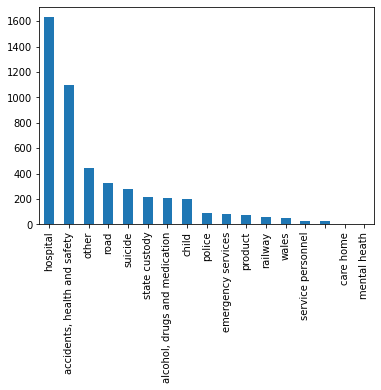

In [299]:
categories_counts = by_la["corrected categories"].explode().value_counts()
categories_counts.plot.bar()

This looks like it follows Zipf’s law, although it’s not obvious whether that’s actually a useful conclusion. Well, let’s try anyway.

<AxesSubplot:xlabel='rank', ylabel='corrected categories'>

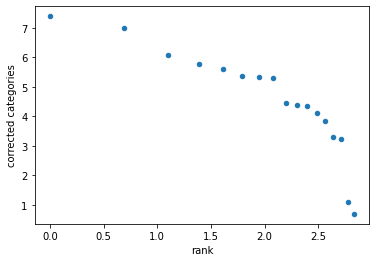

In [300]:
categories_frame = categories_counts.to_frame()
categories_frame.insert(
    loc=0,
    column="rank",
    value=np.arange(1,1+len(categories_frame)))
categories_frame["rank"] = np.log(categories_frame["rank"])
categories_frame["corrected categories"] = np.log(categories_frame["corrected categories"])
categories_frame.plot.scatter(x="rank",y="corrected categories")

Let’s exclude the last two points.

<AxesSubplot:xlabel='rank', ylabel='corrected categories'>

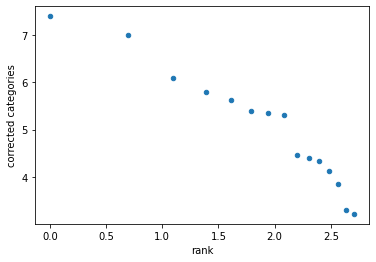

In [301]:
categories_frame = categories_counts.to_frame()
categories_frame.insert(
    loc=0,
    column="rank",
    value=np.arange(1,1+len(categories_frame)))
categories_frame["rank"] = np.log(categories_frame["rank"][:-2])
categories_frame["corrected categories"] = np.log(categories_frame["corrected categories"][:-2])
categories_frame.plot.scatter(x="rank",y="corrected categories")

<AxesSubplot:xlabel='rank', ylabel='corrected categories'>

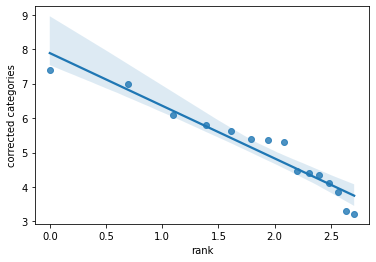

In [312]:
import seaborn as sns
sns.regplot(x=categories_frame["rank"][:-2], y=categories_frame["corrected categories"][:-2])

# Final output

In [303]:
csv_output_corrected = by_la[[
    "url",
    "ref",
    "date of report",
    "deceased name",
    "deceased names",
    "coroner name",
    "corrected area",
    "corrected categories",
    "this report is being sent to",
    "number of links",
    "number of responses",
    "number of recipients",
    "date of reports",
    "category",
    "coroner area"
]].copy()

def process_name(full_name):
    if full_name == "": return ""
    else: return "".join(name[0] for name in full_name.split(" "))

def process_names(names):
    output = []
    and_split = names.split(" and ", 1)
    if len(and_split) > 1: output.append(and_split[1])
    output += and_split[0].split(", ")
    #print(output)
    return ", ".join([process_name(name) for name in output])

csv_output_corrected["deceased names"] = csv_output_corrected["deceased names"].fillna(df["deceased name"])
csv_output_corrected["deceased names"].fillna("",inplace=True)
csv_output_corrected["deceased names"] = csv_output_corrected["deceased names"].apply(process_names)


csv_output_corrected.columns = [
    "url",
    "ref",
    "date of report",
    "deceased name",
    "deceased names",
    "coroner name",
    "area",
    "categories",
    "this report is being sent to",
    "number of links",
    "number of responses",
    "number of recipients",
    "date of reports",
    "categories (uncorrected)",
    "coroner area (uncorrected)",
]

csv_output_corrected = csv_output_corrected.drop(columns = ["deceased name"])

csv_output_corrected.to_csv(f"death_info_{str(date.today())}_processed.csv")
csv_output_corrected.to_csv(f"death_info_latest.csv")

In [310]:
areas.to_csv(f"areas_info_{str(date.today())}.csv")
areas.to_csv(f"areas_info_latest.csv")